# Imports

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import alignment.alignment_utils as utils

# Load in data

In [4]:
DATA_PATH = '../data/'
data_filename = DATA_PATH + 'pt_decoding_data_S22.pkl'

In [5]:
all_pt_data = utils.load_pkl(data_filename)

In [6]:
pt = 'S14'
pt_data = all_pt_data[pt]
print(pt_data.keys())

dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])


# Phoneme label processing

In [7]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [8]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

# Data Visualization

## Setup

In [9]:
p_ind = 1
pt_trace = pt_data[f'X{p_ind}']
pt_phon_labels = pt_data[f'y{p_ind}']
pt_phon_seqs = pt_data['y_full_phon']
pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
pt_cv_labels = labels2cv_seq(pt_phon_seqs)

In [10]:
artic_seq_strs = articic_nums2seq(pt_artic_seqs)
artic_seq_strs = np.array([[s[0:2] + '_' for s in labs] for labs in artic_seq_strs])
artic_seq_strs = utils.label2str(artic_seq_strs)
artic_seq_strs = np.array([s[0:-1] for s in artic_seq_strs])

In [11]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

In [12]:
phon_seq_avg_trace = utils.cnd_avg(pt_trace, pt_phon_seqs_str)
artic_seq_avg_trace = utils.cnd_avg(pt_trace, pt_artic_seqs_str)
phon_avg_trace = utils.cnd_avg(pt_trace, pt_phon_labels)
artic_avg_trace = utils.cnd_avg(pt_trace, pt_artic_labels)
cv_avg_trace = utils.cnd_avg(pt_trace, pt_cv_labels)

## HG Traces (TODO)

## jPCA

In [13]:
import jPCA
from jPCA.util import plot_projections

### Plotting Functions

In [14]:
import matplotlib.patheffects as pe
import plotly.express as px

def custom_plot_traj(ax, x, y, 
                    color="black",
                    outline="black",
                    circle=True,
                    arrow=True,
                    circle_size=0.05,
                    arrow_size=0.05):
    """
    Plot a single neural trajectory in a 2D plane.
    
    Args
    ----
        ax: Axis used for plotting.
        
        x: Values of variable on x-axis.
        
        y: Values of variable on y-axis.
        
        color: Fill color of line to be plotted. Defaults to "black".
        
        outline: Outline color of line. Defaults to "black".
        
        circle: True if the trajectory should have a circle at its starting state.
        
        arrow: True if the trajectory should have an arrow at its ending state.
        
    """
    ax.plot(x, y,
             color=color,
             path_effects=[pe.Stroke(linewidth=2, foreground=outline), pe.Normal()])
        
    if circle:
        circ = plt.Circle((x[0], y[0]),
                          radius=circle_size, 
                          facecolor=color,
                          edgecolor="black")
        ax.add_artist(circ)

    if arrow:
        dx = x[-1] - x[-2]
        dy = y[-1] - y[-2]
        px, py = (x[-1], y[-1])
        ax.arrow(px, py , dx, dy, 
                  facecolor=color, 
                  edgecolor=outline,
                  length_includes_head=True,
                #   head_width=arrow_size,
                #   head_length=arrow_size,
                  width=arrow_size,
                  )

def custom_plot_proj(data_list,
                     cnd_labels,
                     x_idx=0,
                     y_idx=1,
                     axis=None,
                     arrows=True,
                     circles=True,
                     arrow_size=0.05,
                     circle_size=0.05):
    """
    Plot trajectories found via jPCA or PCA. 
    
    Args
    ----
        data_list: List of trajectories, where each entry of data_list is an array of size T x D, 
                   where T is the number of time-steps and D is the dimension of the projection.
        cnd_labels: list of labels for each trajectory to allow for color by condition type
        x_idx: column of data which will be plotted on x axis. Default 0.
        y_idx: column of data which will be plotted on y axis. Default 0.
        arrows: True to add arrows to the trajectory plot.
        circles: True to add circles at the beginning of each trajectory.
        sort_colors: True to color trajectories based on the starting x coordinate. This mimics
                     the jPCA matlab toolbox.
    """
    if axis is None:
        fig = plt.figure(figsize=(5,5))
        axis = fig.add_axes([1, 1, 1, 1])

    colormap = plt.cm.RdBu
    colors = np.array([colormap(i) for i in np.linspace(0, 1, len(data_list))])
    # colors = px.colors.qualitative.Plotly
    # colors = px.colors.qualitative.Alphabet
    # colors = px.colors.sequential.Plasma
    data_list = [data[:, [x_idx, y_idx]] for data in data_list]

    legend_lines = []
    for i, data in enumerate(np.array(data_list)):
        custom_plot_traj(axis,
                        data[:, 0],
                        data[:, 1],
                        color=colors[i],
                        circle=circles,
                        arrow=arrows,
                        arrow_size=arrow_size,
                        circle_size=circle_size)
        line, = axis.plot([], [], color=colors[i], label=cnd_labels[i])
        legend_lines.append(line)
    plt.legend(legend_lines, cnd_labels)
    

### JPCA Analysis

In [15]:
jpca = jPCA.JPCA(num_jpcs=6)

In [16]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=10)
# pca_trace = pca.fit_transform(pt_trace.reshape(-1, pt_trace.shape[-1]))
# pca_trace = pca_trace.reshape(pt_trace.shape[0], pt_trace.shape[1], -1)
# print(pca_trace.shape)

In [17]:
# marker_size = 0.14
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# plot_projections([pca_trace[i] for i in range(pca_trace.shape[0]-142)], axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# plot_projections([pca_trace[i] for i in range(pca_trace.shape[0]-142)], axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)

# axes[0].set_title("PCA Plane 1")
# axes[1].set_title("PCA Plane 2")
# plt.tight_layout()
# plt.show()

In [18]:
t_start = -0.1
t_end = 0.15
t_start_idx = t[np.where(t >= t_start)[0][0]]
t_end_idx = t[np.where(t <= t_end)[0][-1]]
# print(t_start, t_end)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([phon_avg_trace[i] for i in range(phon_avg_trace.shape[0])], times=list(t), tstart=t_start_idx, tend=t_end_idx, align_axes_to_data=True, num_pcs=30)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([artic_seq_avg_trace[i] for i in range(artic_seq_avg_trace.shape[0])], times=list(t), tstart=t_start_idx, tend=t_end_idx, align_axes_to_data=True, num_pcs=30)
projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([artic_avg_trace[i] for i in range(artic_avg_trace.shape[0])], times=list(t), tstart=t_start_idx, tend=t_end_idx, align_axes_to_data=True, num_pcs=30)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([cv_avg_trace[i] for i in range(cv_avg_trace.shape[0])], times=list(t), tstart=t_start_idx, tend=t_end_idx, align_axes_to_data=True, num_pcs=30)
# projected, full_data_var, pca_var_capt, jpca_var_capt = jpca.fit([pt_trace[i] for i in range(pt_trace.shape[0])], times=list(t), tstart=t_start, tend=t_end, align_axes_to_data=True)
print(f'jPCA projection shape: ({len(projected)}, {projected[0].shape[0]}, {projected[0].shape[1]})')


jPCA projection shape: (4, 50, 6)


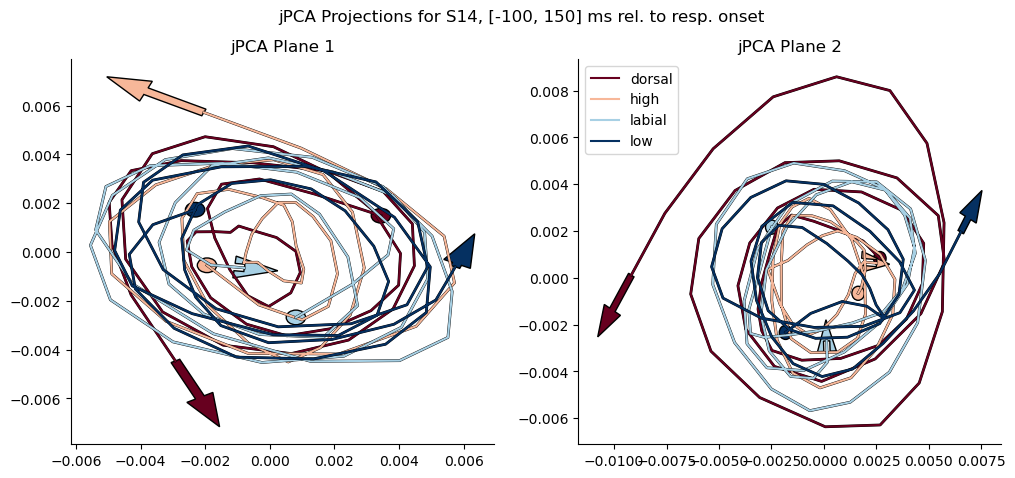

In [19]:
marker_size = 0.0003
# marker_size=0.00003
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# custom_plot_proj(projected, np.unique(pt_cv_labels), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(pt_cv_labels), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
custom_plot_proj(projected, np.unique(artic_labels), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
custom_plot_proj(projected, np.unique(artic_labels), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(artic_seq_strs), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(artic_seq_strs), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(phon_labels), axis=axes[0], x_idx=0, y_idx=1, arrow_size=marker_size, circle_size=marker_size)
# custom_plot_proj(projected, np.unique(phon_labels), axis=axes[1], x_idx=2, y_idx=3, arrow_size=marker_size, circle_size=marker_size)

axes[0].set_title("jPCA Plane 1")
axes[1].set_title("jPCA Plane 2")
# plt.tight_layout()
plt.suptitle(f'jPCA Projections for {pt}, [{round(t_start * 1000)}, {round(t_end * 1000)}] ms rel. to resp. onset')
sns.despine()
plt.show()

In [20]:
# Here's how we would get the variance of first plane:
print("Variance captured by each jPC:")
jpca_var_capt / full_data_var

Variance captured by each jPC:


array([0.00017381, 0.00013411, 0.00018504, 0.00016933, 0.00035844,
       0.00036284])

## dPCA

In [21]:
from dPCA import dPCA

In [54]:
dpca = dPCA.dPCA(labels='st', regularizer='auto')
dpca.protect = ['t']

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


In [55]:
pt_trace_dpca = pt_trace.swapaxes(0, -1)
pt_trace_ps_avg_dpca = phon_seq_avg_trace.swapaxes(0, -1)
pt_trace_ps_avg_dpca = pt_trace_dpca[None]
print(pt_trace_dpca.shape, pt_trace_ps_avg_dpca.shape)

(111, 200, 144) (1, 111, 200, 144)


In [57]:
pt_phons, trial_counts = np.unique(pt_phon_labels, return_counts=True) 

n_stim = len(pt_phons)
n_chans = pt_trace.shape[-1]
n_time = pt_trace.shape[1]
n_samples = np.max(trial_counts)

dpca_trialX = np.nan * np.ones((n_samples, n_chans, n_stim, n_time))
for i, phon in enumerate(pt_phons):
    phon_idx = np.where(pt_phon_labels == phon)[0]
    phon_trials = pt_trace[phon_idx].swapaxes(-2, -1)
    # print(phon_trials.shape, dpca_trialX[:len(phon_trials), :, i, :].shape)
    dpca_trialX[:len(phon_trials), :, i, :] = phon_trials
print(f'Trial-by-trial data shape: {dpca_trialX.shape}')

Trial-by-trial data shape: (24, 111, 9, 200)


In [58]:
from sklearn.impute import SimpleImputer

imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
dpca_trialX = imp_med.fit_transform(dpca_trialX.reshape(n_samples, -1)).reshape(dpca_trialX.shape)

In [59]:
# trial-average data
dpca_X = np.mean(dpca_trialX, 0)

# center data
dpca_X -= np.mean(dpca_X.reshape((n_chans,-1)),1)[:,None,None]

print(f'Trial-average data shape: {dpca_X.shape}')

Trial-average data shape: (111, 9, 200)


In [60]:
dpca_Z = dpca.fit_transform(dpca_X, dpca_trialX)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.002420143235548455
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [62]:
dpca_Z.keys()

dict_keys(['s', 't', 'st'])

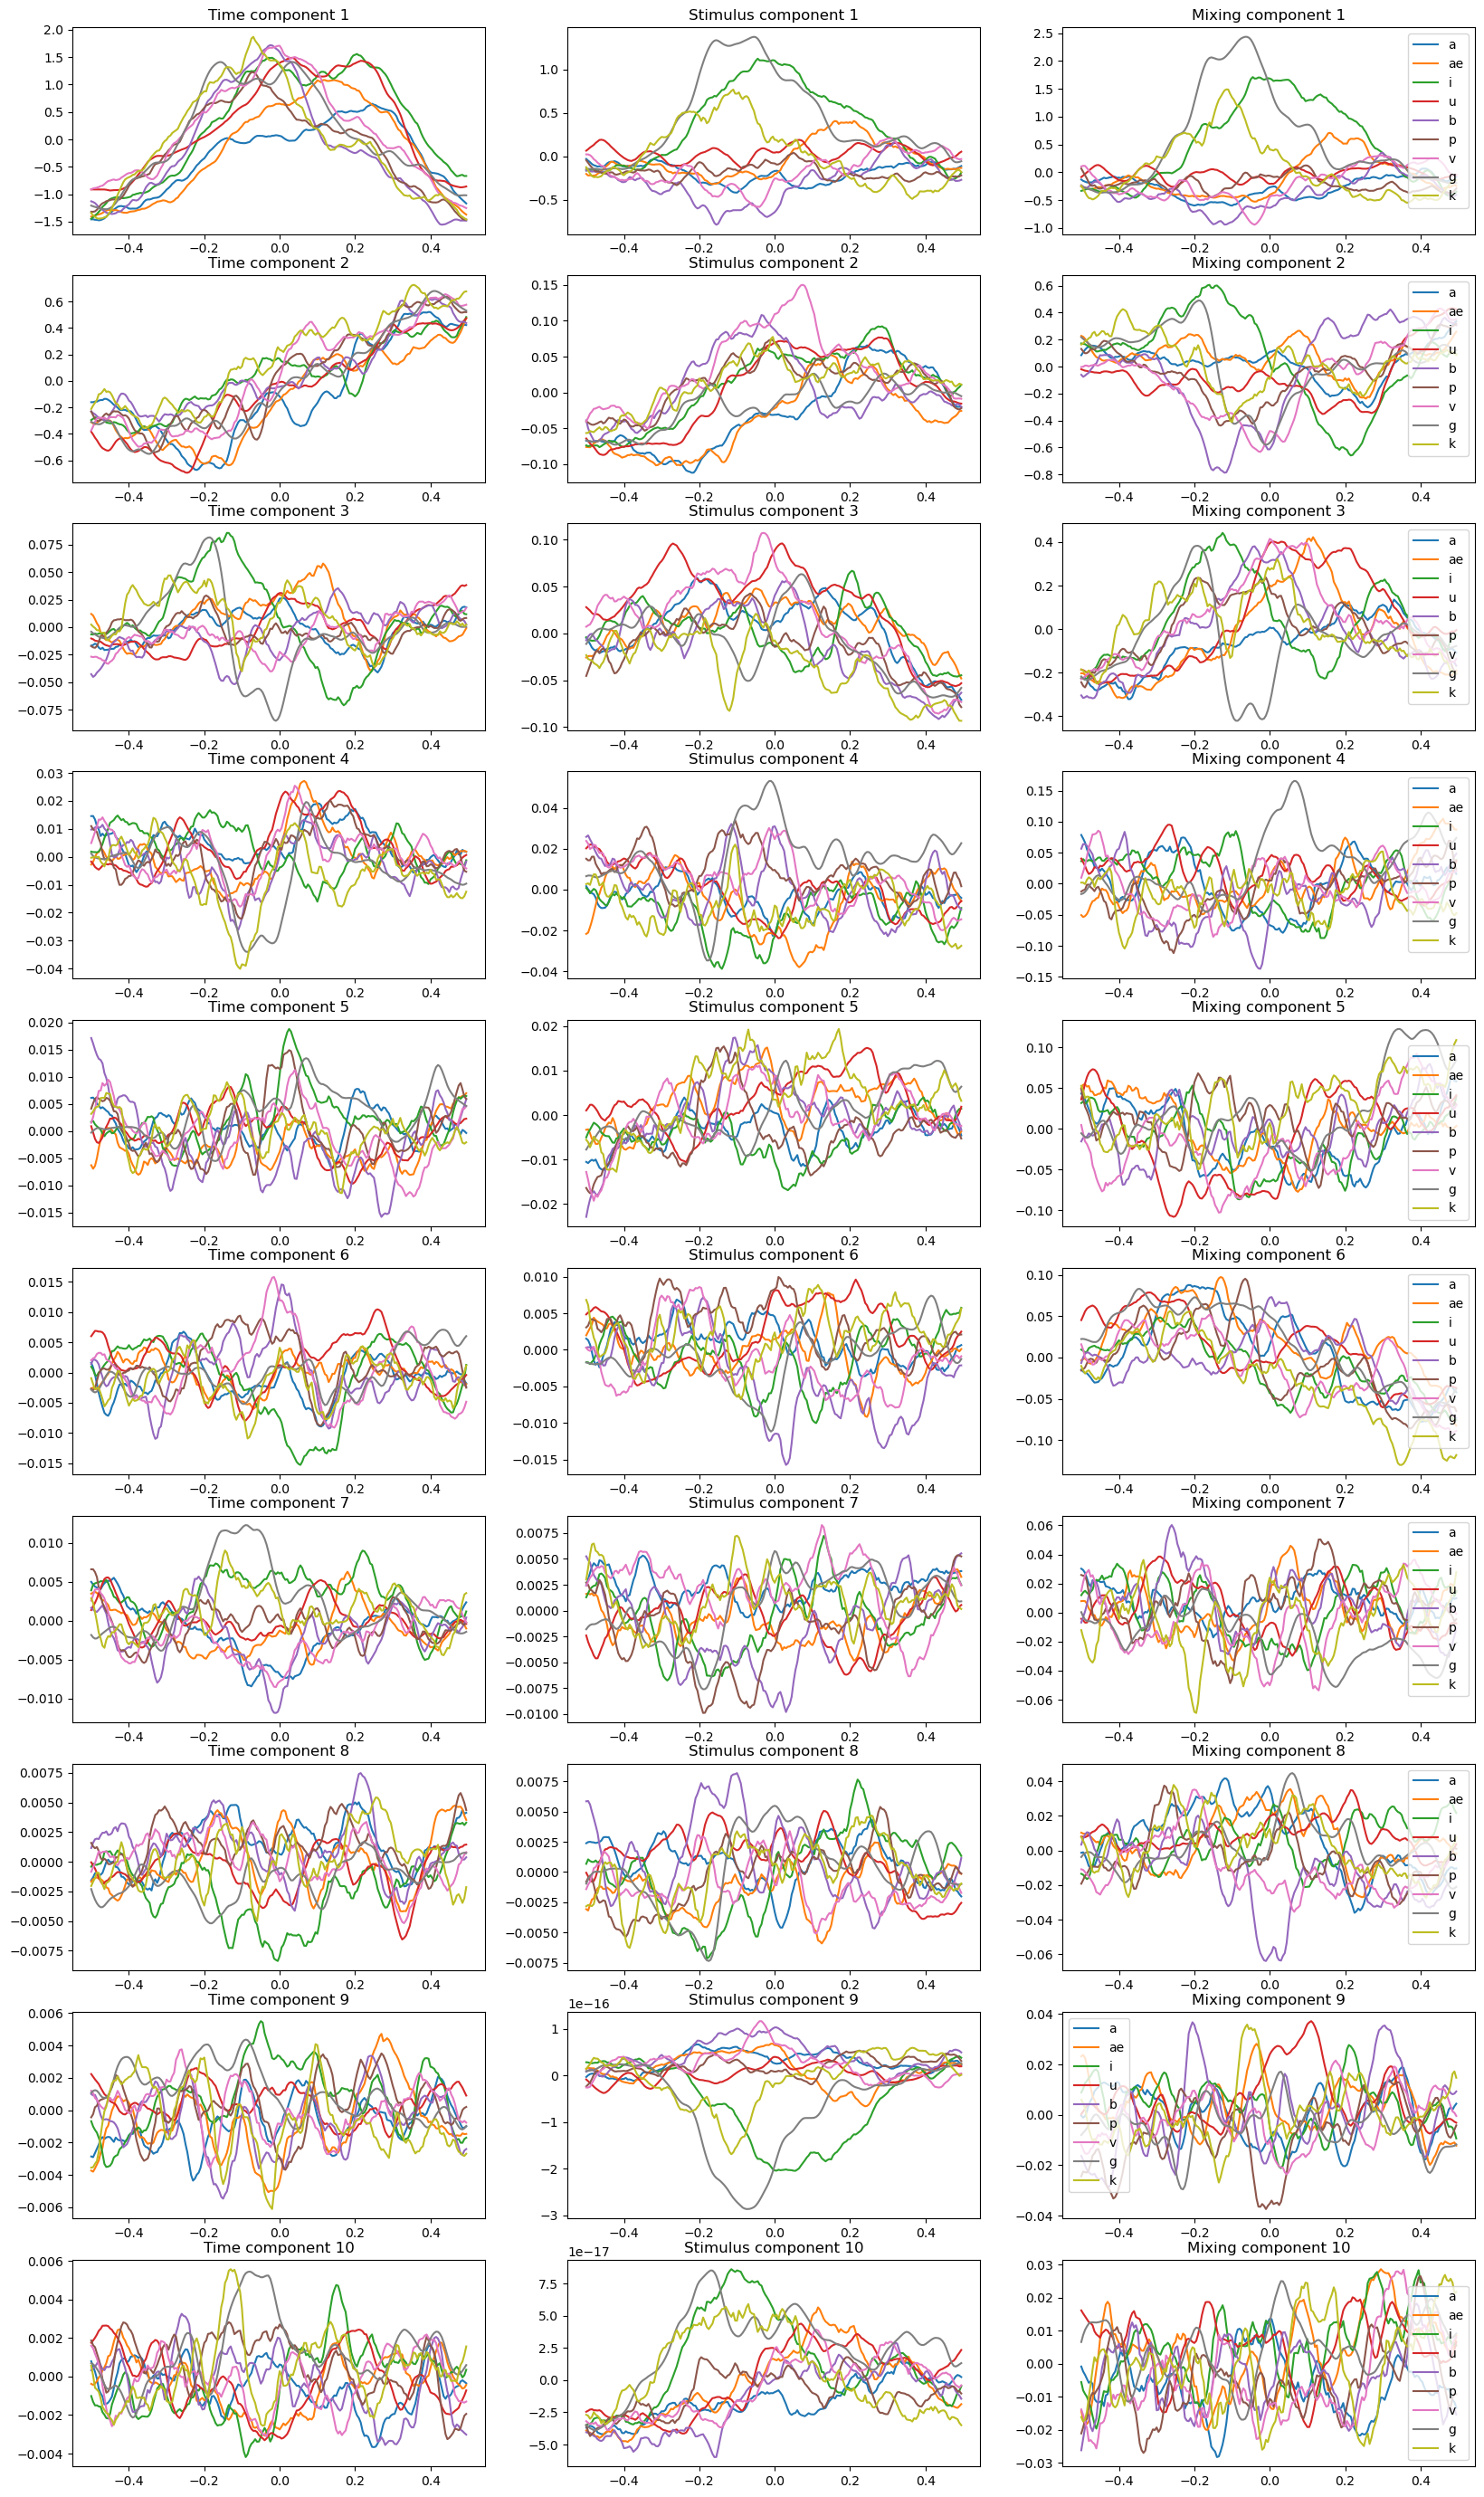

In [77]:
f, axs = plt.subplots(dpca_Z['t'].shape[0], 3, figsize=(20, 35))

for i, ax in enumerate(axs):
    for s in range(n_stim):
        ax[0].plot(t,dpca_Z['t'][i,s], label=phon_labels[pt_phons[s]-1])

    ax[0].set_title(f'Time component {i+1}')

    for s in range(n_stim):
        ax[1].plot(t,dpca_Z['s'][i,s], label=phon_labels[pt_phons[s]-1])
        
    ax[1].set_title(f'Stimulus component {i+1}')

    for s in range(n_stim):
        ax[2].plot(t,dpca_Z['st'][i,s], label=phon_labels[pt_phons[s]-1])
        
    ax[2].set_title(f'Mixing component {i+1}')
    ax[2].legend()
plt.show()

In [66]:
dpca_Z['t'].shape

(10, 9, 200)

## TSNE Scatters

In [50]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [51]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])
zero_ind = np.where(t == 0)[0][0]

perp = 30
tsne_comp = 2

# pt_embed_t0 = TSNE(n_components=tsne_comp, perplexity=perp).fit_transform(pt_trace[:,zero_ind,:])

t_pca_comp = 0.8
pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(pt_trace.reshape(pt_trace.shape[0], -1))
pt_embed_time = TSNE(n_components=tsne_comp, perplexity=perp).fit_transform(pt_time_pca)


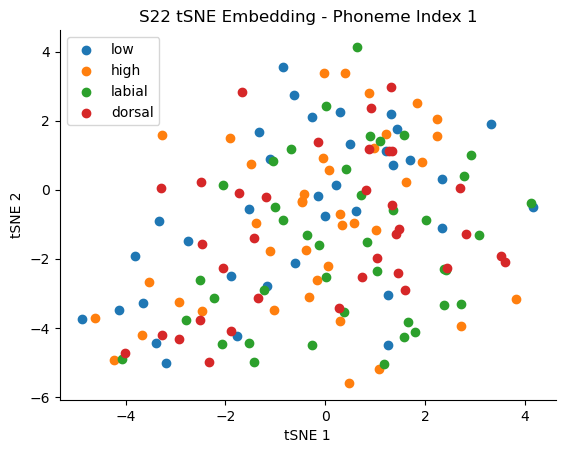

In [52]:
fig_data = pt_embed_time
fig_labels = pt_artic_labels
fig_label_names = artic_labels

plt.figure()
for lab in np.unique(fig_labels):
    plt.scatter(fig_data[np.where(fig_labels == lab)[0],0], fig_data[np.where(fig_labels == lab)[0],1], label=fig_label_names[lab-1])
# plt.scatter(S14_embed_t0[:,0], S14_embed_t0[:,1], c=S14_artic_labels[:,0])
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'{pt} tSNE Embedding - Phoneme Index {p_ind}')
plt.legend()

sns.despine()
plt.show()